In [1]:
import numpy as np
import time
from datetime import datetime
import pandas as pd
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical

from skimage import feature
from skimage.io import imread
from skimage.color import rgb2gray

from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential, Model
from keras import optimizers
from keras.applications import vgg16, mobilenet, resnet, xception
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, TrueNegatives, FalsePositives, AUC
from tensorflow.keras import callbacks
import tensorflow as tf
hora_actual = []
now = datetime.now() # current date and time
hora_actual.append(now.strftime("%d/%m/%Y %H:%M:%S"))


In [2]:
def create_excel(func):
    def wrapper(excel_name, df):
        if not create_excel_file(excel_name):
            return  # No proceder si la creación del archivo falla
        return func(excel_name, df)
    return wrapper

def create_excel_file(excel_name):
    cwd = os.getcwd()  # Obtiene el directorio de trabajo actual
    print("Directorio de trabajo:\n", cwd)
    file_path = os.path.join(cwd, excel_name)  # Ruta del archivo Excel
    if os.path.exists(file_path):
        print("El archivo ya existe en el directorio.")
    else:
        try:
            # Crear un archivo Excel vacío
            with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
                pass  # No hace nada, simplemente crea el archivo
            print("Archivo Excel creado exitosamente en el directorio.")
        except Exception as e:
            print("Error al crear el archivo Excel:", e)
            return False
    return True

@create_excel
def append_data_to_excel(excel_name, df):
    with pd.ExcelWriter(excel_name,
        mode="a",
        engine="openpyxl",
        if_sheet_exists="overlay") as writer:
        start_row = 0
        header = True
        if os.path.exists(excel_name):
            df_source = pd.read_excel(excel_name, engine="openpyxl").iloc[:,1:]
        if df_source is not None:
            n, m = df_source.shape
            header = False if n > 0 else True
            start_row = n + 1 if n > 0 else n

        df.to_excel(writer, sheet_name="Sheet1",startcol=0, startrow = start_row, header=header)

In [3]:
# Función para graficar progreso durante el entrenamiento de la red
def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label = 'Validación')
    plt.xlabel('Iteración (epoch)')
    plt.ylabel('Exactitud (accuracy)')
    plt.ylim([0, 1])
    plt.grid()
    #plt.title('Modelo '+str(i+1))
    plt.title('Modelo '+str(1))
    plt.legend(loc='lower right')
    plt.show()


In [4]:
def load_data(path):
    X, y = [], []
    #1205 es la menor cantidad de img en cada clase
    for label in CLASSES:
        for img in os.listdir(os.path.join(path, label))[:100]: # OJO for img in os.listdir(os.path.join(path, label))[:1205]:
            full_path = os.path.join(path, label, img)
            image = cv2.imread(full_path)
            image = cv2.resize(image, SIZE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = np.asarray(image).astype(np.float32) / 255.0
            X.append(image)
            y.append(CLASSES.index(label))

    y = to_categorical(y, num_classes=NUM_CLASSES)
    y = np.argmax(y, axis=1)
    return np.array(X), np.array(y)

In [5]:
SIZE = (112, 112)
TRAIN_PATH = './dataset'
CLASSES = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
NUM_CLASSES = len(CLASSES)
print(CLASSES)

['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [6]:
X_train, y_train = load_data(TRAIN_PATH)
cant_imag , ancho, alto = X_train.shape

In [7]:
vectores_hog=[]
for i in range(cant_imag):
    vector_caracteristicas = feature.hog(X_train[i], feature_vector=True)
    vectores_hog.append(vector_caracteristicas)
vectores_hog = np.array(vectores_hog)

In [ ]:
vectores_hog.shape

(500, 11664)

In [8]:
train_img_features , test_img_features , train_labels , test_labels = train_test_split(vectores_hog, y_train, test_size=0.3, shuffle=True)



Epoch 1/3


18/18 [==============================] - 2s 30ms/step - loss: 1.6399 - accuracy: 0.2314 - val_loss: 1.6294 - val_accuracy: 0.1200
Epoch 2/3
18/18 [==============================] - 0s 22ms/step - loss: 1.5619 - accuracy: 0.2429 - val_loss: 1.6111 - val_accuracy: 0.1533
Epoch 3/3
5/5 [==============================] - 0s 4ms/step - loss: 1.6003 - accuracy: 0.2067
Directorio de trabajo:
 c:\JOSE\Master España\Universidad\Segundo Cuatrimestre\Aprendizaje Automático\Transparencias\Proyecto Final\Colab
El archivo ya existe en el directorio.


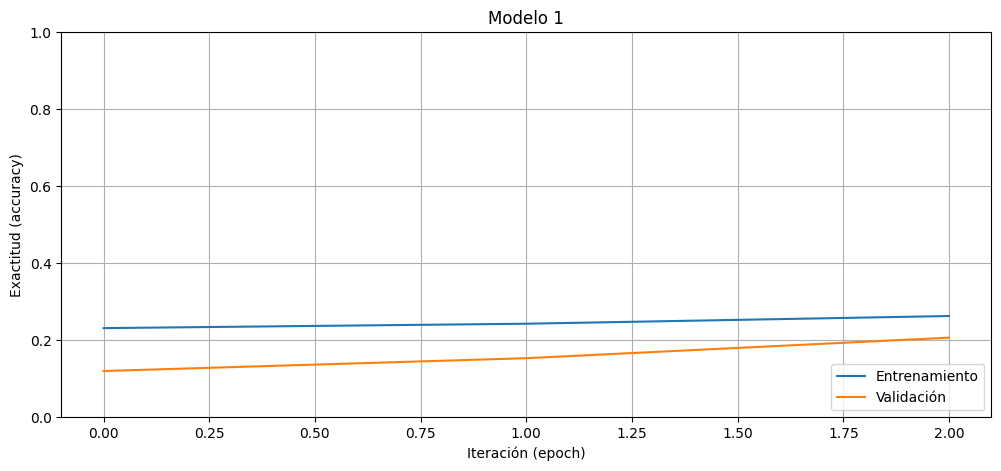

In [9]:
# Esta estructura de CNN hay que encontrar la mejor, porque los modelos son muy malos
def cnn1(_input_shape, NUM_CLASSES):
    model = Sequential()
    model.add(Flatten(input_shape=_input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model
#Parametros de entrenamiento
epochs = 3; batch_size = 20

# Crea el modelo
input_shape = train_img_features.shape[1:]
model = cnn1(input_shape, NUM_CLASSES)

# Compila el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrena el modelo
history = model.fit(train_img_features, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_img_features, test_labels))

#Prediccion del modelo
test_pred_probs = model.predict(test_img_features);
test_pred_probs_ = np.argmax(test_pred_probs, axis=1)

#Metricas
loss , acc = model.evaluate(test_img_features , test_labels)
recall = tf.keras.metrics.Recall()(test_labels, test_pred_probs_).numpy()
precision = tf.keras.metrics.Precision()(test_labels, test_pred_probs_).numpy()
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = tf.keras.metrics.SpecificityAtSensitivity(0.5)(test_labels, test_pred_probs_).numpy() #este valor se ajusta SpecificityAtSensitivity(0.5)
auc = tf.keras.metrics.AUC()(test_labels, test_pred_probs_).numpy()

test_data = {
        'base model'    : "cnn4",
        'out layers'    : "3",  #estas son las tres utlias capas de la estrcutura de la red que escogimos
        'extra params'  : model.count_params(),
        'epochs'        : epochs,
        'batch size'    : batch_size,
        'accuracy'      : round(acc,2),
        'recall'        : round(recall,2),
        'specificity'   : round(specificity,2),
        'precision'     : round(precision,2),
        'f1_score'      : round(f1_score,2),
        'auc'           : round(auc,2),
        'train time'    : " - ",
        'eval time'     : " - "
        }
time_ = []
time_.append(now.strftime("%d/%m/%Y %H:%M:%S"))
df = pd.DataFrame(test_data, index = time_)
append_data_to_excel("./HOG_ANN.xlsx", df)

plot_history(history)